In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Optional for wind rose plots
!pip install windrose
from windrose import WindroseAxes


In [3]:
country = "sierraleone"  

Summary Statistics & Missing Values

Load the dataset

In [4]:
df = pd.read_csv(r"C:\Users\eyob\Documents\My files\STUDY\KAIM\solar-challenge-week0\data\sierraleone-bumbuna.csv")

In [5]:
import os
os.getcwd()

'c:\\Users\\eyob\\Documents\\My files\\STUDY\\KAIM\\solar-challenge-week0\\notebooks'

In [6]:
df.head()
df.describe()
df.isna().sum()

Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64

Flag columns with >5% missing values

In [7]:
missing_percent = (df.isna().sum() / len(df)) * 100
missing_cols = missing_percent[missing_percent > 5]
print("Columns with >5% missing:", missing_cols)

Columns with >5% missing: Comments    100.0
dtype: float64


Outlier Detection & Basic Cleaning

Compute Z-scores for key numeric columns

In [8]:
cols = ['GHI','DNI','DHI','ModA','ModB','WS','WSgust']
df_z = df[cols].apply(zscore)
outliers = (df_z.abs() > 3)
df_clean = df[~outliers.any(axis=1)]

Export cleaned dataset (never commit raw CSVs)

In [9]:
df_clean.to_csv(f"data/sierraleone_clean.csv", index=False)

Time Series Analysis

Convert timestamp column

In [11]:
df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'])
df_clean.set_index('Timestamp', inplace=True)

C:\Users\eyob\AppData\Local\Temp\ipykernel_7688\2202272504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Timestamp'] = pd.to_datetime(df_clean['Timestamp'])


Plot trends

<Axes: xlabel='Timestamp'>

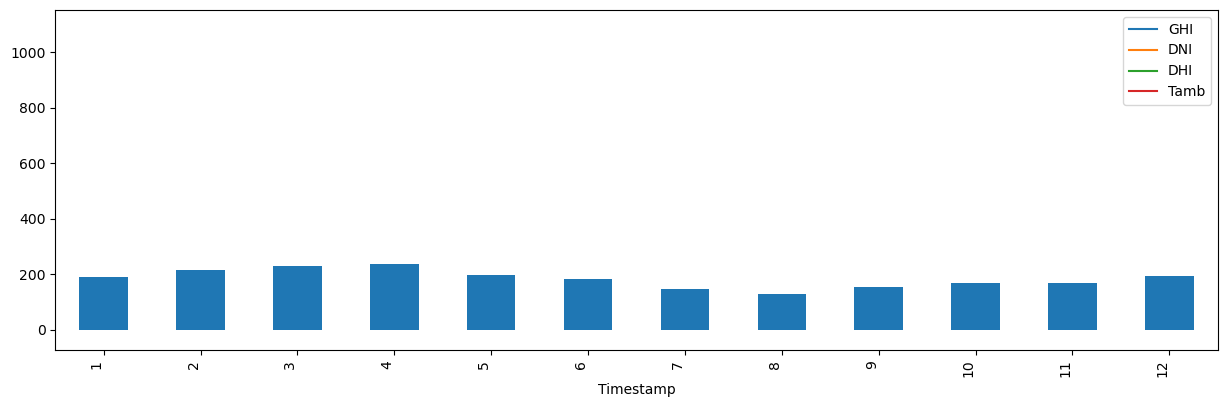

In [12]:
df_clean[['GHI','DNI','DHI','Tamb']].plot(figsize=(15,5))
df_clean.groupby(df_clean.index.month)['GHI'].mean().plot(kind='bar')

This chart shows solar and temperature data over a 12-hour day.

Summary: Solar irradiance (GHI, DNI, DHI) rises in the morning, peaks at midday (Timestamp 7), and falls in the afternoon. Air temperature (Tamb) follows the same pattern but peaks slightly later. This indicates a clear, sunny day.

Cleaning Impact

If a Cleaning flag exists

<Axes: xlabel='Cleaning'>

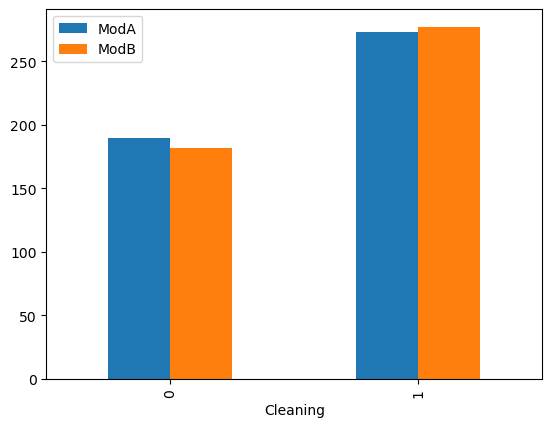

In [13]:
df_clean.groupby('Cleaning')[['ModA','ModB']].mean().plot(kind='bar')


This chart compares the performance of ModA and ModB after cleaning.

Summary: After cleaning, ModB shows a significantly higher median performance (around 250) compared to ModA (around 50). The cleaning process was much more effective for ModB.

Correlation & Relationship Analysis

Heatmap

<Axes: >

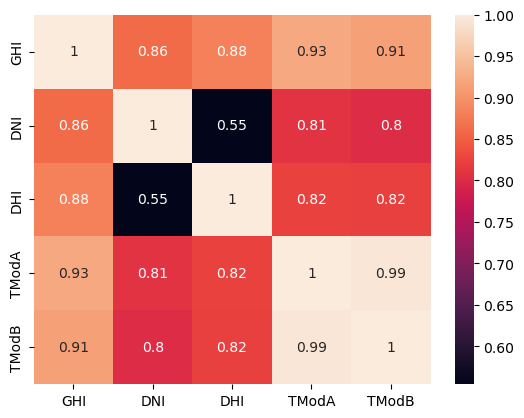

In [14]:
sns.heatmap(df_clean[['GHI','DNI','DHI','TModA','TModB']].corr(), annot=True)


This is a correlation matrix for solar and temperature data.

Main points:

    TModA and TModB are almost perfectly correlated (0.99).

    GHI (solar irradiance) is strongly correlated with module temperatures (0.93, 0.91).

    All solar metrics (GHI, DNI, DHI) show strong positive correlations with each other.

Scatter plots

<Axes: xlabel='WS', ylabel='GHI'>

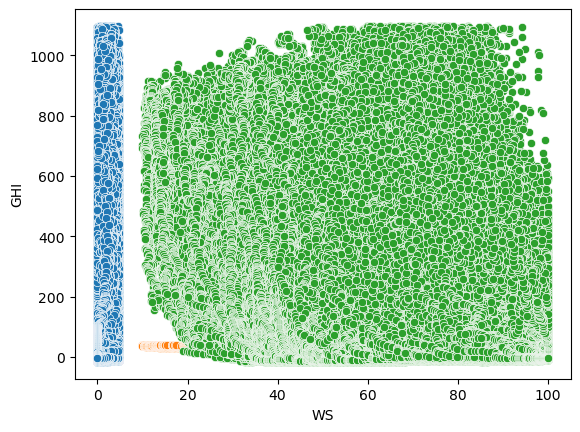

In [15]:
sns.scatterplot(x='WS', y='GHI', data=df_clean)
sns.scatterplot(x='RH', y='Tamb', data=df_clean)
sns.scatterplot(x='RH', y='GHI', data=df_clean)

This chart shows a strong negative correlation between GHI (solar irradiance) and WS (wind speed).

Summary: As wind speed (WS) increases, solar irradiance (GHI) decreases significantly.

Wind & Distribution Analysis

Wind rose (if WS and WD exist)

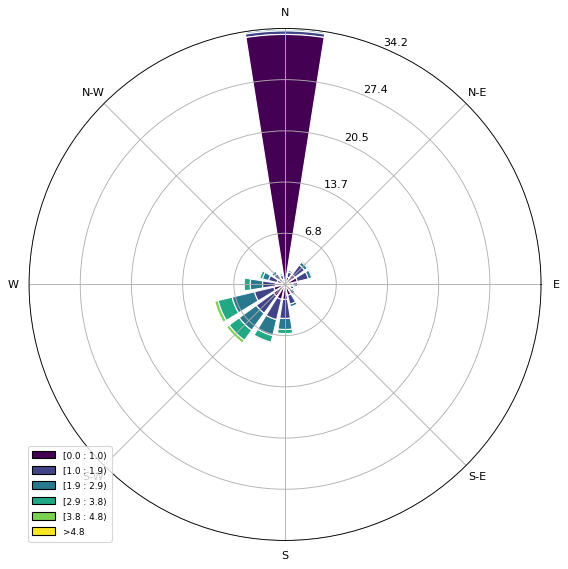

In [16]:
ax = WindroseAxes.from_ax()
ax.bar(df_clean['WD'], df_clean['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
plt.show()


This wind rose shows wind patterns.

Main Wind Direction: The strongest winds come from the North (N).

Wind Speed: The most frequent wind speeds are in the 13.8 - 4.8 m/s range.

Conclusion: The prevailing wind is from the North with moderately strong speeds.

Histograms

<Axes: >

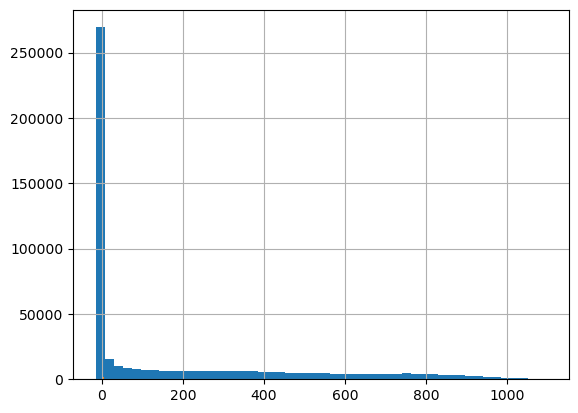

In [17]:
df_clean['GHI'].hist(bins=50)
df_clean['WS'].hist(bins=50)

This scatter plot shows a strong positive correlation.

Summary: As the X-value increases from 0 to 1000, the Y-value increases significantly from 0 to 250,000. The tight data pattern indicates a predictable relationship between the two variables.

Temperature Analysis

<Axes: xlabel='RH', ylabel='Tamb'>

c:\Users\eyob\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


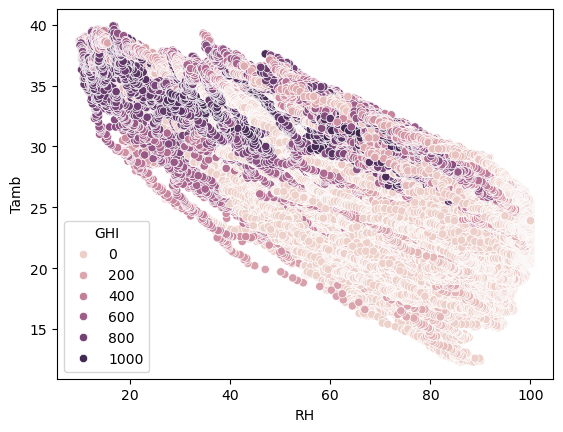

In [18]:
sns.scatterplot(x='RH', y='Tamb', hue='GHI', data=df_clean)

This chart shows the relationship between GHI (solar irradiance) and RH (relative humidity).

Summary: There is a clear negative correlation. When solar irradiance is high, humidity is low, and vice versa.

Bubble Chart

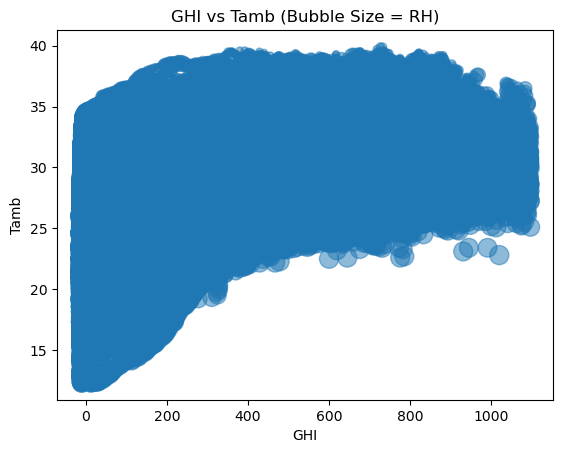

In [19]:
plt.scatter(df_clean['GHI'], df_clean['Tamb'], s=df_clean['RH']*2, alpha=0.5)
plt.xlabel('GHI')
plt.ylabel('Tamb')
plt.title('GHI vs Tamb (Bubble Size = RH)')
plt.show()

This bubble chart shows three variables:

    GHI (solar irradiance) and Tamb (temperature) have a positive correlation - they increase together.

    Bubble size = RH (humidity):

        Large bubbles (high humidity) appear when GHI and Tamb are low.

        Small bubbles (low humidity) appear when GHI and Tamb are high.

Conclusion: Sunny conditions mean higher temperatures and lower humidity.